In [1]:
import math
import random
import gym
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from scipy.special import softmax
from multiprocessing_env import SubprocVecEnv

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device = torch.device('cuda')

# Actor Critic Network

In [4]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)
        

class AC_Network(nn.Module):
    def __init__(self, imput_dims, output_dims, hidden_layer_1, hidden_layer_2):
        super().__init__()
        
        self.critic = nn.Sequential(nn.Linear(imput_dims, hidden_layer_1),
                                    nn.ReLU(),
                                    nn.Linear(hidden_layer_1, hidden_layer_2),
                                    nn.ReLU(),
                                    nn.Linear(hidden_layer_2, 1))
        
        self.actor = nn.Sequential(nn.Linear(imput_dims, hidden_layer_1),
                                    nn.ReLU(),
                                    nn.Linear(hidden_layer_1, hidden_layer_2),
                                    nn.ReLU(),
                                    nn.Linear(hidden_layer_2, output_dims))        
        self.apply(init_weights)
        
    def forward(self, x):
        state_value = self.critic(x)
        action_vector = self.actor(x)
        action_probs = softmax(action_vector.cpu().detach().numpy())
        np.clip(action_probs,1e-10,1,out=action_probs)
        action_distribution  = Categorical(torch.FloatTensor(action_probs).to(device))
        return action_distribution, state_value

# Computing Generalized Advantage Estimation (for smoother training)

In [5]:
def gen_adv_est(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

## Utility Funtions

In [6]:
def plot(rewards, avg_reward):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.plot(rewards,label = 'Reward Per Test Session')
    plt.plot(avg_reward,label = "Average Reward over all Tests")
    plt.legend()
    plt.show()

In [7]:
def test_env(vis=False):
    state = main_env.reset()
    done = False
    average_reward_current_policy = 0
    while (not done):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        action_distribution, _ = model(state.view(1,-1))
        next_state, reward, done, _ = main_env.step(action_distribution.sample().cpu().numpy()[0])
        state = next_state
        if vis: 
            main_env.render()
        average_reward_current_policy += reward
    return average_reward_current_policy

# Proximal Policy Optimization Algorithm

In [8]:
def ppo_step(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]

In [9]:
def ppo_parameter_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):
    for _ in range(ppo_epochs):
        for state, action, prev_log_probs, return_, advantage in ppo_step(mini_batch_size, states, actions, log_probs, returns, advantages):
            action_distribution, state_value = model(state)
            entropy = action_distribution.entropy().mean()
            new_log_probs = action_distribution.log_prob(action)

           
            #Ratio of current policy over old policy in logarithmic space
            log_ratio = (new_log_probs - prev_log_probs).exp()
            
            #surrogate losses (for actor)
            surrogate_loss_1 = log_ratio * advantage
            surrogate_loss_2 = torch.clamp(log_ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage
            
            #following are the actor and critic network losses which will be combined in the next step.
            actor_loss  = - torch.min(surrogate_loss_1, surrogate_loss_2).mean()
            critic_mse_loss = (return_ - state_value).pow(2).mean()

            #Combined loss function to update both actor and critic network
            combined_loss = 0.5 * critic_mse_loss + actor_loss - 0.001 * entropy

            optimizer.zero_grad()
            combined_loss.backward()
            optimizer.step()

# Training Function.

## After every 500 steps of training, we test the policy on the actual environment and record rewards.

In [10]:
def start_learning(envs, max_steps, curr_step, test_reards, avg_reward, moving_average_over_tests):
    state = envs.reset()
    while curr_step < max_steps:
        log_probs = []
        values = []
        states = []
        actions = []
        rewards = []
        masks = []
        entropy = 0
        for step in range(steps):
            state = torch.FloatTensor(state).to(device)
            state = state.view(num_envs,-1)
            action_distribution, value = model(state)
            action = action_distribution.sample()
            next_state, reward, done, _ = envs.step(action.cpu().numpy())

            log_prob = action_distribution.log_prob(action)
            entropy += action_distribution.entropy().mean()

            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
            masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))

            states.append(state)
            actions.append(action)

            state = next_state
            curr_step += 1

            if curr_step % 500 == 0:
                test_reward = np.mean([test_env() for _ in range(8)])
                test_rewards.append(test_reward)
                moving_average_over_tests += ((1/len(test_rewards)) * (test_reward - moving_average_over_tests))
                avg_reward.append(moving_average_over_tests)
                plot(test_rewards, avg_reward)

        next_state = torch.FloatTensor(next_state).to(device)
        _, next_value = model(next_state.view(num_envs,-1))
        returns = gen_adv_est(next_value, rewards, masks, values)

        returns   = torch.cat(returns).detach()
        log_probs = torch.cat(log_probs).detach()
        values    = torch.cat(values).detach()
        states    = torch.cat(states)
        actions   = torch.cat(actions)
        advantage = returns - values

        ppo_parameter_update(ppo_epochs, mini_batch_size, states, actions.unsqueeze(1), log_probs.unsqueeze(1), returns, advantage)

# Starting Training ... 

## Initializing Environment Vectors for Atari Space Invaders

In [11]:
num_envs = 18

In [12]:
env_name = "SpaceInvaders-v0"
def make_env():
    def _envs():
        env = gym.make(env_name)
        return env

    return _envs

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

In [13]:
main_env = gym.make(env_name)

# Model Parameters

In [14]:
input_dims  = envs.observation_space.shape[0]*envs.observation_space.shape[1]*envs.observation_space.shape[2]
output_dims = 6
hidden_layer_1  = 1024
hidden_layer_2  = 256
ac_network_alpha = 1e-3
steps = 16
mini_batch_size = 6
ppo_epochs = 6

In [15]:
model = AC_Network(input_dims, output_dims, hidden_layer_1, hidden_layer_2).to(device)
optimizer = optim.Adam(model.parameters(), lr=ac_network_alpha)

In [16]:
max_steps = 8000
curr_step  = 0
test_rewards = []
avg_reward = []
moving_average_over_tests = 0

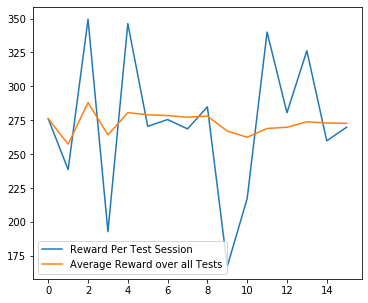

In [17]:
start_learning(envs, max_steps, curr_step, test_rewards, avg_reward, moving_average_over_tests)

## Initializing Environment Vectors for Atari BreakOut

In [18]:
num_envs = 6

In [19]:
env_name = "Breakout-v0"
def make_env():
    def _envs():
        env = gym.make(env_name)
        return env

    return _envs

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

In [20]:
main_env = gym.make(env_name)

## Model Parameters

In [21]:
input_dims  = envs.observation_space.shape[0]*envs.observation_space.shape[1]*envs.observation_space.shape[2]
output_dims = 4
hidden_layer_1  = 1024
hidden_layer_2  = 256
ac_network_alpha = 1e-3
steps = 20
mini_batch_size = 6
ppo_epochs = 6

In [22]:
model= AC_Network(input_dims, output_dims, hidden_layer_1, hidden_layer_2).to(device)
optimizer = optim.Adam(model.parameters(), lr=ac_network_alpha)

In [23]:
max_steps = 8000
curr_step  = 0
test_rewards = []
avg_reward = []
moving_average_over_tests = 0

In [ ]:
start_learning(envs, max_steps, curr_step, test_rewards, avg_reward, moving_average_over_tests)

## We ran into a few issues while training for Breakout. We successfully generated a graph of rewards vs testing sessions but we were not satisfied with the results hence we thought of hyperparameter tuning, unfortunately we could not complete the training for 15000 steps as it was taking a long time to converge. We had to abort the training. Kindly consider the graph that is put in the report for Atari Breakout.